<a href="https://colab.research.google.com/github/fabrito2006/Laboratorio-9-MID/blob/main/Laboratorio_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 09 - Mineria de Datos
## Alumno: Torres Alvaradao Fabricio Ismael
## Ciclo y carrera: 5C28A

## 1. En esta ocasión se hará la implementación de una red neuronal de clasificación y otra red neuronal convolucional, tomando un 20% de datos de prueba para ambos casos:

### a. Mediante la base a datos de cáncer de mama alojados en el repositorio UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29) y utilizando la librería de Python ‘scikit-learn’, cree una red neuronal para clasificar a un paciente como canceroso o no canceroso de tal forma que obtenga el mayor valor de accuracy. Para ello, debe realizar el preprocesamiento de la información e ir ajustando la red neuronal con los parámetros requeridos como la cantidad de capas ocultas y neuronas por cada capa oculta, el número de iteraciones, la función de activación, el método para minimizar la función de error, entre otros.

#### Leemos la base de datos

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

# Concat data
data = pd.concat([X, y], axis=1)

In [4]:
data.head(10)

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2
5,8,10,10,8,7,10.0,9,7,1,4
6,1,1,1,1,2,10.0,3,1,1,2
7,2,1,2,1,2,1.0,3,1,1,2
8,2,1,1,1,2,1.0,1,1,5,2
9,4,2,1,1,2,1.0,2,1,1,2


#### Imputamos los datos nulos

In [5]:
# Visualizamos los valores nulos
columnas_nulas = data.columns[data.isnull().any()]
print(columnas_nulas)
data.isnull().sum()

Index(['Bare_nuclei'], dtype='object')


,0
Clump_thickness,0
Uniformity_of_cell_size,0
Uniformity_of_cell_shape,0
Marginal_adhesion,0
Single_epithelial_cell_size,0
Bare_nuclei,16
Bland_chromatin,0
Normal_nucleoli,0
Mitoses,0
Class,0


In [6]:
# Funcion para rellenar con la mediana
def rellenar_nulos_con_mediana(data, columnas):
    for columna in columnas:
        mediana = data[columna].median()
        data[columna] = data[columna].apply(lambda x: mediana if pd.isnull(x) else x)
        print(f"Se ha rellenado la columna '{columna}' con la mediana: {mediana}")
    return data

In [7]:
# Rellenar columnas
data = rellenar_nulos_con_mediana(data, columnas_nulas)

Se ha rellenado la columna 'Bare_nuclei' con la mediana: 1.0


#### Tratamiento de outliers

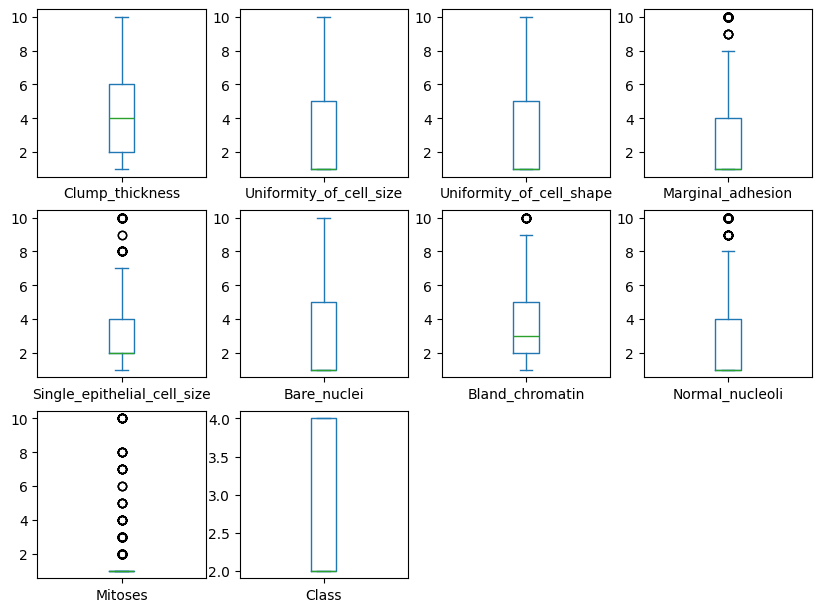

In [8]:
# Visualizamos los outliers
import matplotlib.pyplot as plt
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(10,10))
plt.show()

In [9]:
# Funcion para hallar los outliers
def cap_outliers_iqr(data, var):
    Q1 = data[var].quantile(0.25)
    Q3 = data[var].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    data[var] = data[var].apply(lambda x: lim_sup if x > lim_sup else (lim_inf if x < lim_inf else x))
    return data

In [10]:
# Aplica el capping a todas las columnas excepto 'Mitoses' y 'Class'
for var in data.columns:
    if var not in ['Mitoses', 'Class']:
        data = cap_outliers_iqr(data, var)

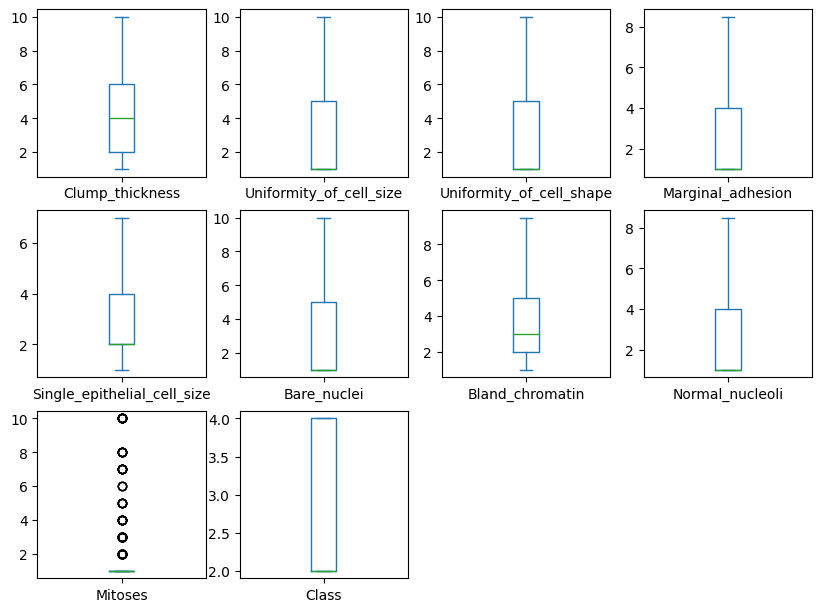

In [11]:
# Verificmaos los outliers
import matplotlib.pyplot as plt
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(10,10))
plt.show()

#### Desbalanceo de Clases

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Clump_thickness              699 non-null    int64  
 1   Uniformity_of_cell_size      699 non-null    int64  
 2   Uniformity_of_cell_shape     699 non-null    int64  
 3   Marginal_adhesion            699 non-null    float64
 4   Single_epithelial_cell_size  699 non-null    float64
 5   Bare_nuclei                  699 non-null    float64
 6   Bland_chromatin              699 non-null    float64
 7   Normal_nucleoli              699 non-null    float64
 8   Mitoses                      699 non-null    int64  
 9   Class                        699 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 54.7 KB


In [42]:
X = data.drop('Class', axis=1)
y = data['Class']

<ipython-input-38-0aa5a7fe41fb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class',data=data, palette = 'hls')


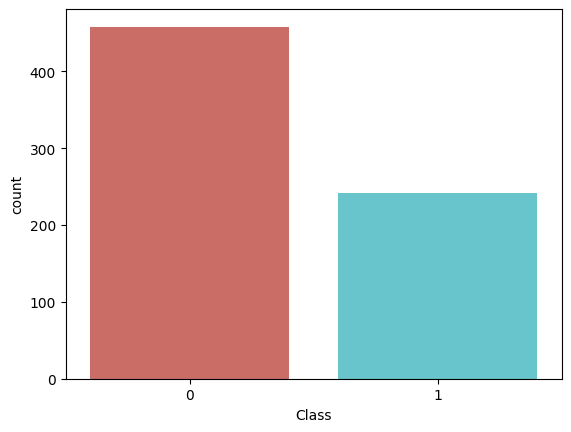

<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
694    0
695    0
696    1
697    1
698    1
Name: Class, Length: 699, dtype: int64>


In [38]:
import seaborn as sns
sns.countplot(x='Class',data=data, palette = 'hls')
plt.show()
print(data['Class'].value_counts)

In [41]:
# Reemplazamos valores
data['Class'] = data['Class'].replace({2: 0, 4: 1})
print(data['Class'].value_counts)

<bound method IndexOpsMixin.value_counts of 0      0
1      0
2      0
3      0
4      0
      ..
694    0
695    0
696    1
697    1
698    1
Name: Class, Length: 699, dtype: int64>


In [43]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(sampling_strategy='minority')
X_bal, y_bal = smote.fit_resample(X,y)
print('Distribución antes del SMOTE {}'.format(Counter(y)))
print('Distribución después del SMOTE {}'.format(Counter(y_bal)))

Distribución antes del SMOTE Counter({0: 458, 1: 241})
Distribución después del SMOTE Counter({0: 458, 1: 458})


#### Red neuronal de clasificación

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.20, random_state=99)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
from sklearn.neural_network import MLPClassifier
rna_clf = MLPClassifier(hidden_layer_sizes=(100,200,100),
                        max_iter = 500, alpha = 0.0001, activation = 'relu',
                        solver = 'adam', random_state = 23, tol = 0.000000001)
rna_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 200, 100), max_iter=500, random_state=23,
              tol=1e-09)

In [47]:
y_prob = rna_clf.predict_proba(X_test)
y_prob

array([[9.99999991e-01, 9.36267970e-09],
       [8.66726690e-11, 1.00000000e+00],
       [1.00000000e+00, 1.13558402e-15],
       [2.22044605e-16, 1.00000000e+00],
       [7.08322290e-14, 1.00000000e+00],
       [1.00000000e+00, 1.31074486e-15],
       [1.00000000e+00, 2.75872524e-14],
       [2.06075135e-09, 9.99999998e-01],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.33226763e-15, 1.00000000e+00],
       [1.00000000e+00, 6.22620976e-12],
       [1.29973587e-10, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [3.01980663e-14, 1.00000000e+00],
       [9.94112652e-01, 5.88734842e-03],
       [9.99999982e-01, 1.81086790e-08],
       [2.87523422e-05, 9.99971248e-01],
       [1.00000000e+00, 5.12118980e-15],
       [1.00000000e+00, 4.54688379e-13],
       [3.55271368e-15, 1.00000000e+00],
       [1.00000000e+00, 8.62774508e-12],
       [4.20552482e-13, 1.00000000e+00],
       [5.98471745e-06, 9.99994015e-01],
       [1.000000

In [48]:
y_pred = rna_clf.predict(X_test)
y_pred

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [49]:
pd.crosstab(y_test,y_pred, rownames=['Real'], colnames=['Predicho'])

Predicho,0,1
Real,,
0,77,6
1,5,96


In [50]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Exactitud = ', accuracy_score(y_test,y_pred))
print('Precisión = ', precision_score(y_test,y_pred))
print('Sensibilidad = ', recall_score(y_test,y_pred))
print('Puntuación F1 = ', f1_score(y_test,y_pred))

Exactitud =  0.9402173913043478
Precisión =  0.9411764705882353
Sensibilidad =  0.9504950495049505
Puntuación F1 =  0.9458128078817734


#### Función para hallar la red neuronal con mayor accuracy

In [51]:
from sklearn.model_selection import train_test_split
import itertools

def buscar_mejor_rna(X, y, parametros):
    mejores_resultados = {
        'accuracy': 0,
        'modelo': None,
        'parametros': None
    }

    # Crear todas las combinaciones de parámetros
    keys = parametros.keys()
    valores = parametros.values()
    for combinacion in itertools.product(*valores):
        params = dict(zip(keys, combinacion))

        modelo = MLPClassifier(
            hidden_layer_sizes=params['hidden_layer_sizes'],
            alpha=params['alpha'],
            max_iter=params['max_iter'],
            activation=params['activation'],
            solver='adam',
            random_state=99,
            tol=1e-5
        )

        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        print(f"Probando {params} -> Accuracy: {acc:.4f}")

        if acc > mejores_resultados['accuracy']:
            mejores_resultados['accuracy'] = acc
            mejores_resultados['modelo'] = modelo
            mejores_resultados['parametros'] = params

    print(f"\nMejor accuracy: {mejores_resultados['accuracy']:.4f} con parámetros: {mejores_resultados['parametros']}")
    return mejores_resultados['modelo'], mejores_resultados['accuracy'], mejores_resultados['parametros']

In [52]:
parametros = {
    'hidden_layer_sizes': [(50,), (50,25), (100,50,25)],
    'alpha': [0.0001, 0.001],
    'max_iter': [300, 500],
    'activation': ['relu', 'tanh']
}

mejor_modelo, mejor_acc, mejor_params = buscar_mejor_rna(X, y, parametros)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'max_iter': 300, 'activation': 'relu'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'max_iter': 300, 'activation': 'tanh'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'max_iter': 500, 'activation': 'relu'} -> Accuracy: 0.9457


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'max_iter': 500, 'activation': 'tanh'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.001, 'max_iter': 300, 'activation': 'relu'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.001, 'max_iter': 300, 'activation': 'tanh'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.001, 'max_iter': 500, 'activation': 'relu'} -> Accuracy: 0.9457


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50,), 'alpha': 0.001, 'max_iter': 500, 'activation': 'tanh'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.0001, 'max_iter': 300, 'activation': 'relu'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.0001, 'max_iter': 300, 'activation': 'tanh'} -> Accuracy: 0.9565


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.0001, 'max_iter': 500, 'activation': 'relu'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.0001, 'max_iter': 500, 'activation': 'tanh'} -> Accuracy: 0.9620


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.001, 'max_iter': 300, 'activation': 'relu'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.001, 'max_iter': 300, 'activation': 'tanh'} -> Accuracy: 0.9565


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.001, 'max_iter': 500, 'activation': 'relu'} -> Accuracy: 0.9511


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (50, 25), 'alpha': 0.001, 'max_iter': 500, 'activation': 'tanh'} -> Accuracy: 0.9620
Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.0001, 'max_iter': 300, 'activation': 'relu'} -> Accuracy: 0.9402


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.0001, 'max_iter': 300, 'activation': 'tanh'} -> Accuracy: 0.9620
Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.0001, 'max_iter': 500, 'activation': 'relu'} -> Accuracy: 0.9402
Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.0001, 'max_iter': 500, 'activation': 'tanh'} -> Accuracy: 0.9511
Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.001, 'max_iter': 300, 'activation': 'relu'} -> Accuracy: 0.9402


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.001, 'max_iter': 300, 'activation': 'tanh'} -> Accuracy: 0.9620
Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.001, 'max_iter': 500, 'activation': 'relu'} -> Accuracy: 0.9402
Probando {'hidden_layer_sizes': (100, 50, 25), 'alpha': 0.001, 'max_iter': 500, 'activation': 'tanh'} -> Accuracy: 0.9511

Mejor accuracy: 0.9620 con parámetros: {'hidden_layer_sizes': (50, 25), 'alpha': 0.0001, 'max_iter': 500, 'activation': 'tanh'}


In [53]:
#### Creamos el modelo con mejor accuracy
from sklearn.neural_network import MLPClassifier
rna_clf1 = MLPClassifier(hidden_layer_sizes=(50,25),
                        max_iter = 300, alpha = 0.0001, activation = 'tanh',
                        solver = 'adam', random_state = 99, tol = 0.00001)
rna_clf1.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 25), max_iter=300,
              random_state=99, tol=1e-05)

In [54]:
y_prob = rna_clf1.predict_proba(X_test)
y_pred = rna_clf1.predict(X_test)

In [55]:
pd.crosstab(y_test,y_pred, rownames=['Real'], colnames=['Predicho'])

Predicho,0,1
Real,,
0,77,6
1,2,99


In [56]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Exactitud = ', accuracy_score(y_test,y_pred))
print('Precisión = ', precision_score(y_test,y_pred))
print('Sensibilidad = ', recall_score(y_test,y_pred))
print('Puntuación F1 = ', f1_score(y_test,y_pred))

Exactitud =  0.9565217391304348
Precisión =  0.9428571428571428
Sensibilidad =  0.9801980198019802
Puntuación F1 =  0.9611650485436893


### b. Tome la base de datos llamada ‘Fashion MNIST’ (https://github.com/zalandoresearch/fashion-mnist) la cual consiste de 60 000 fotos (28×28 pixeles por cada imagen) de prendas de ropa e importándola directamente desde ‘keras’, cree una red neuronal convolucional que sirva para clasificar las imágenes respecto al tipo de ropa mostrado (10 tipos distintos de artículos) de tal forma que se obtenga el mayor valor de accuracy. Para ello, deberá ir ajustando la red neuronal con los parámetros requeridos como la cantidad de capas ocultas y neuronas por cada capa oculta, el número de iteraciones, la función de activación, el método para minimizar la función de error, entre otros.

#### Importar base de datos

In [57]:
!pip install keras==2.9.0
!pip3 install pyqt5=5.12.0
!pip install --ignore-installed --upgrade tensorflow --user

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires keras>=3.5.0, but you have keras 2.9.0 which is incompatible.
ERROR: Invalid requirement: 'pyqt5=5.12.0': Expected end or semicolon (after name and no valid version specifier)
    pyqt5=5.12.0
         ^
Hint: = is not a valid operator. Did you mean == ?
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 857.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 8.5 MB/s eta 0:00:

In [1]:
from tensorflow.keras.datasets import fashion_mnist

# Cargar el dataset (ya viene separado en entrenamiento y prueba)
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<function matplotlib.pyplot.show(close=None, block=None)>

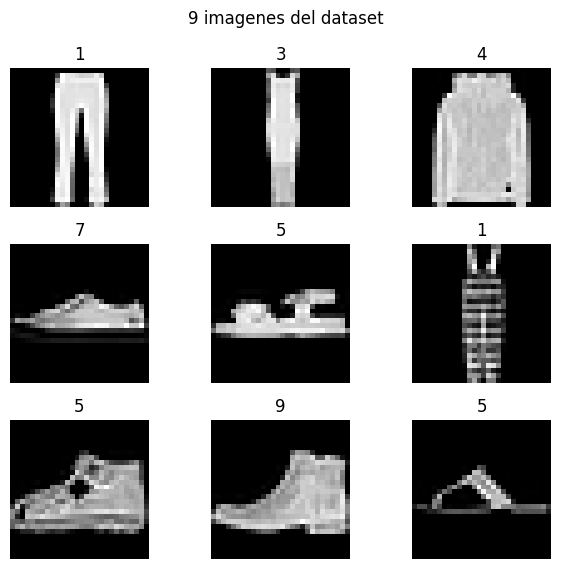

In [2]:
import matplotlib.pyplot as plt
import numpy as np
ids_imgs = np.random.randint(0,X_train.shape[0],9)
fig = plt.figure(figsize=(6,6))
for i in range(len(ids_imgs)):
  plt.suptitle('9 imagenes del dataset')
  img = X_train[ids_imgs[i],:,:]
  plt.subplot(3,3,i+1)
  fig.tight_layout()
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  plt.title(y_train[ids_imgs[i]])
plt.show

In [3]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

In [4]:
X_train = X_train/255.0
X_test = X_test/255.0

In [5]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

In [6]:
np.random.seed(1)
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
modelo = Sequential()
modelo.add(Dense(15,input_dim = input_dim,activation='relu'))
modelo.add(Dense(output_dim, activation='softmax'))

/root/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=0.02)
modelo.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [9]:
historia = modelo.fit(X_train,y_train,epochs=30,batch_size=100,verbose=1)

Epoch 1/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5145 - loss: 1.4310
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7841 - loss: 0.6440
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8123 - loss: 0.5560
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8221 - loss: 0.5147
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8331 - loss: 0.4821
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8344 - loss: 0.4746
Epoch 7/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8407 - loss: 0.4591
Epoch 8/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8443 - loss: 0.4513
Epoch 9/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8478 - loss: 0.4436
Epoch 10/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8495 - loss: 0.4374
Epoch 11/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8518 - loss: 0.4250
Epoch 12/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

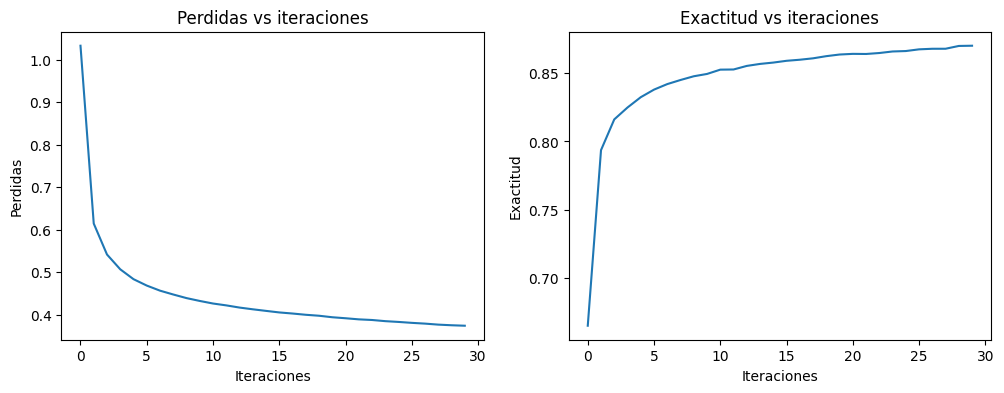

In [10]:
fig = plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(historia.history['loss'])
plt.title('Perdidas vs iteraciones')
plt.xlabel('Iteraciones')
plt.ylabel('Perdidas')

plt.subplot(1,2,2)
plt.plot(historia.history['accuracy'])
plt.title('Exactitud vs iteraciones')
plt.xlabel('Iteraciones')
plt.ylabel('Exactitud')

plt.show()

In [11]:
accuracy = modelo.evaluate(X_test,y_test,verbose=1)
print('Exactitud en el set de evaluación: {:1f}%'.format(100*accuracy[1]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8535 - loss: 0.4266
Exactitud en el set de evaluación: 85.009998%


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


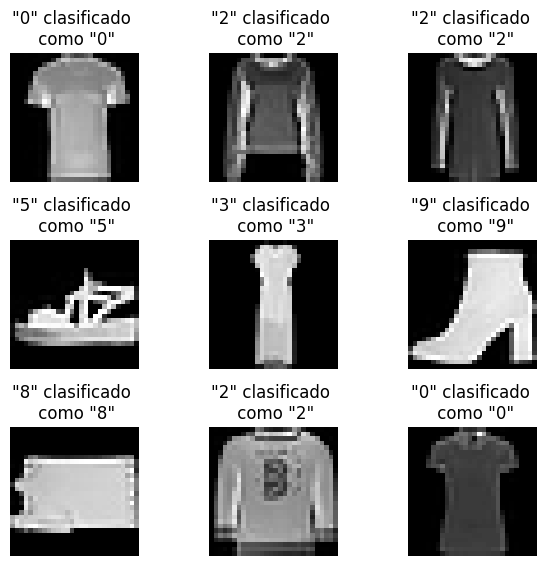

In [16]:
y_pred = np.argmax(modelo.predict(X_test),axis=-1)

ids_imgs = np.random.randint(0,X_test.shape[0],9)
fig = plt.figure(figsize=(6,6))
for i in range(len(ids_imgs)):
  idx = ids_imgs[i]
  img = X_test[idx,:].reshape(28,28)
  cat_original = np.argmax(y_test[idx,:])
  cat_prediccion = y_pred[idx]
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title('"{}" clasificado \n como "{}"'.format(cat_original,cat_prediccion))
plt.show()